In [1]:
import numpy as np
import matplotlib.pyplot as plt
from neurodsp.sim import sim_powerlaw

# Circulant Matrices and Eigendecomposition


PCA is eigendecomposition of a covariance matrix:

$$
\begin{align*}
X^{\top}X = Q \Lambda Q^{\top}
\end{align*}
$$

Let $Q$ be fourier modes (cosines), then the eigenvalues (e.g. fourier coefficients is matrix is circular) is:

$$
\begin{align*}
\Lambda = Q^{\top}(X^{\top}X) Q
\end{align*}
$$

Circulancy of a matrix may be measured using the mean squared error between $\Lambda$ and $\Lambda \odot I$:

$$
\begin{align*}
\epsilon &= \frac{1}{n}||\Lambda - \Lambda \odot I||^2_2.
\end{align*}
$$

$\epsilon \to 0$ indicates a circulant matrix, e.g. cosine eigenvectors, and occurs when the $\Lambda$ is diagonal. Non-zero values in the off-diagonal increases $\epsilon$. 

$\epsilon$ can be computed for any arbitrary matrix and is a measure of whether oscillatory eigenvectors should be expected.

## Temporal Shifts

As shown in Shinn 2023, temporal shifts result in "phantom" oscillitions, thus $\epsilon \to 0$.

In [2]:
def sim_circulant(sig):
    """Simulates a circulant matrix."""
    n = len(sig)
    X = np.zeros((n, n))
    for i in range(len(sig)):
        X[i] = np.roll(sig, i)
    return X

Text(0.5, 1.0, 'Temporal Shifts')

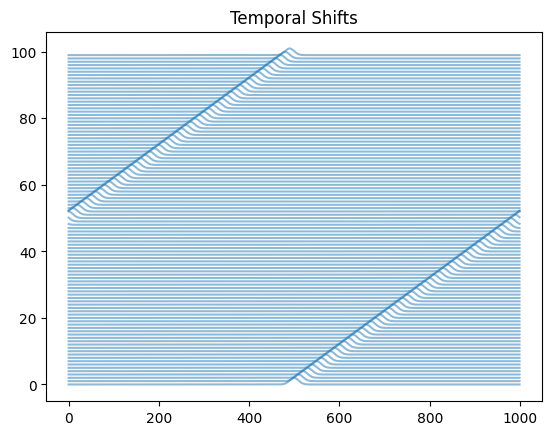

In [3]:
# Simulate temporally shifted gaussians as in Shinn 2024
sigma = 2
x = np.linspace(-100, 100, 1000)
gaussian = 10 * np.exp(-0.5 * (x/sigma)**2) / (sigma * np.sqrt(2 * np.pi))

X = sim_circulant(gaussian)
for i, x in enumerate(X[::10]):
    plt.plot(x+i, color='C0', alpha=.5)

plt.title('Temporal Shifts')

In [4]:
# Covariance matrix
cov = np.cov(X, rowvar=False)
n = len(cov)

# Fourier modes (e.g. cosines)
vecs = np.fft.fft(np.eye(n)) / np.sqrt(n)

# Eigenvalues given cosines as eigenvectors
Lambda = (vecs.conj().T @ cov @ vecs).real

# Error measure
epsilon = (1/n) * np.linalg.norm((Lambda * np.eye(len(Lambda))) - Lambda)**2

# Epsilon -> zero == circulant matrix == oscillatory eigenvectors
print(epsilon)

3.219311809290201e-32


## Powerlaws

From Shinn 2023: "phantom oscillations always appear as a 1/f -like pattern which decreases with increasing frequency". This is actually a "bug" or nature of powerlaw simulations (see [here](https://github.com/neurodsp-tools/neurodsp/issues/326]) for a description of the phenomenon and solution). This results in samples at the beginning of the powerlaw simulation being correlated with samples at the end. This can be corrected for in the simulation.

First we show that the uncorrected simulations produces a circulant matrix, e.g. "phantom" oscillations / oscillatory eigenvectors / $\epsilon \to 0$. Then powerlaw simulations are corrected via zero-padding and the "phantom" oscillations dissapear.

## Uncorrected Powerlaw Simulations

As the number of simulations increases, phantom oscillations emerge.

In [5]:
# Simulate powerlaws and stack row-wise
X = np.array([
    sim_powerlaw(1, 1000, exponent=-2)
    for i in range(10000)
])

In [6]:
n = 1000

# Fourier modes (e.g. cosines)
vecs = np.fft.fft(np.eye(n)) / np.sqrt(n)

# Increase number of simulations step-wise
for i in range(1000, len(X), 1000):

    # Covariance matrix
    cov = np.cov(X[:i], rowvar=False)
    
    # Eigenvalues given cosines as eigenvectors
    Lambda = (vecs.conj().T @ cov @ vecs).real
    
    # Error measure
    epsilon = (1/n) * np.linalg.norm((Lambda * np.eye(len(Lambda))) - Lambda)**2
    
    print(f"n rows = {i}, epsilon = {epsilon}")

n rows = 1000, epsilon = 0.38055574273675247
n rows = 2000, epsilon = 0.21840437047506964
n rows = 3000, epsilon = 0.13891791243070525
n rows = 4000, epsilon = 0.08866914326094215
n rows = 5000, epsilon = 0.06709874417404499
n rows = 6000, epsilon = 0.0610229896263485
n rows = 7000, epsilon = 0.05827231726500436
n rows = 8000, epsilon = 0.04258064142001013
n rows = 9000, epsilon = 0.04021199757151355


## Correction via Zero-Padding

Powerlaw simulations are "corrected" by zero-padding the white noise input. Another solutions is to simulate powerlaws as in neurodsp, the then only take the first half of the signal.

In [7]:
from scipy.stats import zscore
from scipy.fft import fft, fftfreq, ifft, rfft, rfftfreq, irfft

def rotate_spectrum(freqs, spectrum, delta_exponent, f_rotation=1):

    if freqs[0] == 0:
        skipped_zero = True
        f_0, p_0 = freqs[0], spectrum[0]
        freqs, spectrum = freqs[1:], spectrum[1:]
    else:
        skipped_zero = False

    mask = (np.abs(freqs) / f_rotation)**-delta_exponent
   
    rotated_spectrum = mask * spectrum 
    
    if skipped_zero:
        rotated_spectrum = np.insert(rotated_spectrum, 0, p_0)
    
    return rotated_spectrum


def rotate_timeseries(sig, fs, delta_exp, f_rotation=1):

    # Compute the FFT
    fft_vals = rfft(sig)
    freqs = rfftfreq(len(sig), 1./fs)

    # Rotate the spectrum to create the exponent change
    #   Delta exponent is divided by two, as the FFT output is in units of amplitude not power
    fft_rotated = rotate_spectrum(freqs, fft_vals, delta_exp/2, f_rotation)
    
    # Invert back to time series, with a z-score to normalize
    sig_rotated = irfft(fft_rotated)

    return sig_rotated
    
def _create_powerlaw(n_samples, fs, exponent):

    # Start with white noise signal, that we will rotate, in frequency space
    sig = np.random.randn(int(n_samples))
    sig = np.pad(sig, (1000, 1000))
    
    # Create the desired exponent by spectrally rotating the time series
    sig = rotate_timeseries(sig, fs, -exponent)[1000:-1000]

    # z-score to normalize
    sig = zscore(sig)

    return sig

# Simulate powerlaws
exponent = -2
n_sims = 10000
n_samples = 1000
X = np.zeros((n_sims, n_samples))

for i in range(n_sims):
    X[i] = _create_powerlaw(n_samples, 1000, exponent)

$\epsilon$ does not go to zero and eigenvectors are not oscillatory!:

In [8]:
n = n_samples

# Fourier modes (e.g. cosines)
vecs = np.fft.fft(np.eye(n)) / np.sqrt(n)

for i in range(1000, len(X), 1000):

    # Covariance matrix
    cov = np.cov(X[:i], rowvar=False)

    # Eigenvalues given cosines as eigenvectors
    Lambda = (vecs.conj().T @ cov @ vecs).real
    
    # Error measure
    epsilon = (1/n) * np.linalg.norm((Lambda * np.eye(len(Lambda))) - Lambda)**2
    
    print(f"n rows = {i}, epsilon = {epsilon}")

n rows = 1000, epsilon = 32.33933037503692
n rows = 2000, epsilon = 36.83636902777199
n rows = 3000, epsilon = 37.951309990273934
n rows = 4000, epsilon = 37.356705368343945
n rows = 5000, epsilon = 36.6317420907498
n rows = 6000, epsilon = 37.14612105926057
n rows = 7000, epsilon = 36.338963638385664
n rows = 8000, epsilon = 36.04596226669884
n rows = 9000, epsilon = 36.38378925585978
